TODO List:
- Try normalizing all samples to use coordinates relative to an origin at the centroid of the 3 participating hotspots for that sample
- Try clustering or creating binned "zones" for lat/long that are directly predicted like tokens

In [51]:
import numpy as np
import random
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
import pandas as pd
from typing import List, Tuple
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from common import geo_to_cartesian_m, cartesian_to_geo

# Helper Functions

In [52]:
RADIUS_EARTH_KM = 6373.0
RADIUS_EARTH_M = RADIUS_EARTH_KM * 1000

def enforce_safe_lat_long(lat_long_deg):
    """
    Normalize point to [-90, 90] latitude and [-180, 180] longitude.
    """
    lat_long_deg = 1.0 * lat_long_deg
    lat_long_deg[:, 0] = (lat_long_deg[:, 0] + 90) % 360 - 90
    mask = lat_long_deg[:, 0] > 90
    lat_long_deg[mask, 0] = 180 - lat_long_deg[mask, 0]
    lat_long_deg[mask, 1] += 180
    lat_long_deg[:, 1] = (lat_long_deg[:, 1] + 180) % 360 - 180
    return lat_long_deg

# Assuming normalized lat/long contains values in range -1:1... return de-normalized values as true lat/long
def denorm_lat_long(normalized_lat_long):
    lat_long = (normalized_lat_long + 1.0) / 2.0
    lat_long[:, 0] *= 180.0
    lat_long[:, 0] -= 90.0
    lat_long[:, 1] *= 360.0
    lat_long[:, 1] -= 180.0
    return enforce_safe_lat_long(lat_long)

def normalize_lat_long(lat_long_deg):
    """ Normalizes lat/long to range -1:1 """
    lat_long = enforce_safe_lat_long(lat_long_deg=lat_long_deg)
    lat_long[:,0] = 1 - 2 * (lat_long[:,0] + 90.0) / 180.0
    lat_long[:,1] = 1 - 2 * (lat_long[:,1] + 180.0) / 360.0
    return lat_long

def convert_lat_long_to_cart_xyz_TORCH(lat_long_deg: Tensor)->Tensor:
    lat = torch.deg2rad(lat_long_deg[:,0])
    lon = torch.deg2rad(lat_long_deg[:,1])
    return torch.stack([
        torch.sin(np.pi / 2.0 - lat) * torch.cos(lon), # x
        torch.sin(np.pi / 2.0 - lat) * torch.sin(lon), # y
        torch.cos(np.pi / 2.0 - lat)                   # z
    ]).T


def haversine_np(lat_long_deg_1, lat_long_deg_2, radius:float=1.0):
    """
    Calculate the great circle distance between two points on a sphere
    ie: Shortest distance between two points on the surface of a sphere
    """
    lat_1, lon_1, lat_2, lon_2 = map(np.deg2rad, [lat_long_deg_1[:,0], lat_long_deg_1[:,1], lat_long_deg_2[:,0], lat_long_deg_2[:,1]])
    d = np.sin((lat_2 - lat_1)/2)**2 + np.cos(lat_1)*np.cos(lat_2) * np.sin((lon_2 - lon_1)/2)**2
    arc_len = 2 * radius * np.arcsin(np.sqrt(d))
    return arc_len
    
def haversine_torch(lat_long_deg_1:Tensor, lat_long_deg_2:Tensor, radius:float=1.0)->Tensor:
    """
    Calculate the great circle distance between two points on a sphere
    ie: Shortest distance between two points on the surface of a sphere
    """
    lat_1, lon_1, lat_2, lon_2 = map(torch.deg2rad, [lat_long_deg_1[:,0], lat_long_deg_1[:,1], lat_long_deg_2[:,0], lat_long_deg_2[:,1]])
    d = torch.sin((lat_2 - lat_1)/2)**2 + torch.cos(lat_1)*torch.cos(lat_2) * torch.sin((lon_2 - lon_1)/2)**2
    arc_len = 2 * radius * torch.arcsin(torch.sqrt(d))
    return arc_len


def equirectangular_np(lat_long_deg_1, lat_long_deg_2, radius:float=1.0):
    """
    Simplified version of haversine for small distances where 
    Pythagoras theorem can be used on an equirectangular projection
    """
    lat_1, lon_1, lat_2, lon_2 = map(np.deg2rad, [lat_long_deg_1[:,0], lat_long_deg_1[:,1], lat_long_deg_2[:,0], lat_long_deg_2[:,1]])
    x = (lon_2 - lon_1) * np.cos(0.5 * (lat_2 - lat_1))
    y = lat_2 - lat_1
    return radius * np.sqrt(x*x + y*y)
    
def equirectangular_torch(lat_long_deg_1:Tensor, lat_long_deg_2:Tensor, radius:float=1.0)->Tensor:
    """
    Simplified version of haversine for small distances where 
    Pythagoras theorem can be used on an equirectangular projection
    """
    lat_1, lon_1, lat_2, lon_2 = map(torch.deg2rad, [lat_long_deg_1[:,0], lat_long_deg_1[:,1], lat_long_deg_2[:,0], lat_long_deg_2[:,1]])
    x = (lon_2 - lon_1) * torch.cos(0.5 * (lat_2 - lat_1))
    y = lat_2 - lat_1
    return radius * torch.sqrt(x*x + y*y)

def str_contains_sub(s, subs)->bool:
    if isinstance(subs, str):
        subs = [subs]
    for sub in subs:
        if sub in s:
            return True
    return False

# Data

In [53]:
data = pd.read_csv("data/mappers_processed.csv")
if "id" in data.columns:
    data = data.drop(["id"], axis=1)

In [54]:
data.head()

,target_lat,target_long,target_altitude,frequency,spreading_factor,hotspot1_lat,hotspot1_long,hotspot1_altitude,hotspot1_rssi,hotspot1_snr,...,hotspot3_altitude,hotspot3_rssi,hotspot3_snr,hotspot3_fspl_dist_km,centroid_projected_lat,centroid_projected_long,centroid_projected_altitude,naive_tri_lat,naive_tri_long,naive_tri_alt
0,44.305403,-96.806407,0,904.099976,SF7BW125,44.304234,-96.780698,1,-117.0,-2.8,...,1,-118.0,-4.000000,20.954801,44.306248,-96.835499,-9.313226e-10,44.306275,-96.835571,-0.699261
1,50.720951,-1.876882,0,868.299988,SF10BW125,50.715620,-1.883604,1,-112.0,-12.0,...,1,-120.0,-16.200001,27.468200,50.721014,-1.874791,9.313226e-10,50.720917,-1.874805,0.956498
2,36.144499,-86.792449,0,904.299988,SF9BW125,36.152221,-86.791273,1,-85.0,7.2,...,1,-102.0,-0.200000,3.320378,36.166415,-86.811108,0.000000e+00,36.166416,-86.811109,0.093582
3,33.228809,-117.011214,0,904.299988,SF7BW125,33.302632,-116.852721,1,-100.0,4.8,...,1,-122.0,-9.200000,33.203776,33.216687,-116.812595,0.000000e+00,33.216730,-116.812679,-27.404049
4,36.146766,-86.795201,0,904.299988,SF9BW125,36.196064,-86.850049,1,-106.0,0.2,...,1,-112.0,1.200000,10.499956,36.164133,-86.810141,-9.313226e-10,36.164163,-86.810180,-0.010777


In [55]:
# Limit to SF Bay
lat_bounds = [37, 38]
long_bounds = [-124, -122]

data = data[data["target_lat"] > lat_bounds[0]]
data = data[data["target_lat"] < lat_bounds[1]]
data = data[data["target_long"] > long_bounds[0]]
data = data[data["target_long"] < long_bounds[1]]

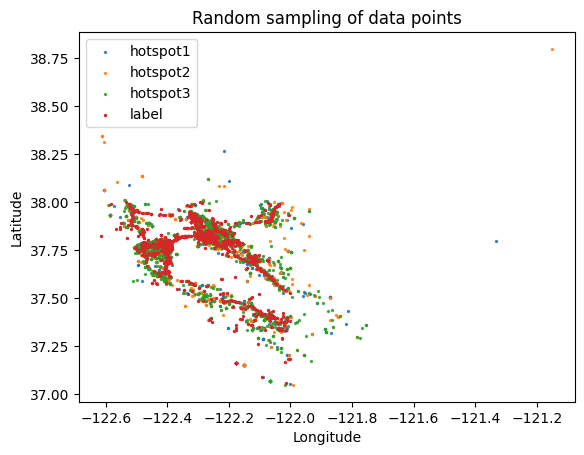

In [56]:
# Visualize some samples
subset = data.sample(n=min(len(data), 2500))
for i in range(1,4):
    plt.scatter(subset[f"hotspot{i}_long"], subset[f"hotspot{i}_lat"], s=2, alpha=0.8, label=f"hotspot{i}")
plt.scatter(subset["target_long"], subset["target_lat"], s=2, label="label")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Random sampling of data points")
plt.legend()

@ q=0.5,	 km=0.70km
@ q=0.9,	 km=7.09km
@ q=0.99,	 km=28.03km
@ q=0.995,	 km=37.16km
@ q=0.999,	 km=51.81km
@ q=0.9999,	 km=74.16km


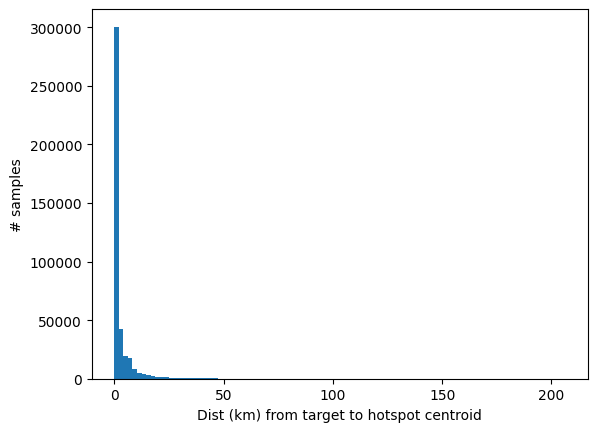

In [57]:
from haversine import haversine_vector, Unit
# For each sample, calculate an average haversine distance between the target and the hotspot centroid
ll_target = data[["target_lat", "target_long"]].to_numpy()
ll_centroid = data[["centroid_projected_lat", "centroid_projected_long"]].to_numpy()
dist_to_centroid_km = haversine_vector(
    array1=ll_target, array2=ll_centroid, unit=Unit.KILOMETERS
)
data["dist_to_centroid_km"] = dist_to_centroid_km
for q in [0.5, 0.9, 0.99, 0.995, 0.999, 0.9999]:
    km = np.quantile(data["dist_to_centroid_km"], q)
    print(f"@ q={q},\t km={km:.2f}km")

plt.hist(dist_to_centroid_km, bins=100)
plt.ylabel("# samples")
plt.xlabel("Dist (km) from target to hotspot centroid")
plt.show()

Removed 2066 sample.


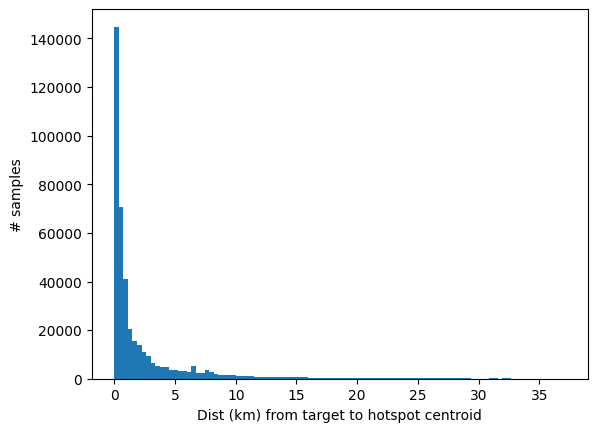

In [58]:
# filter data by REMOVING outliers that represent EXTREMELY distant targets
q = 0.995
threshold_km = np.quantile(data["dist_to_centroid_km"], q)
n_before = len(data)
data = data[data["dist_to_centroid_km"] <= threshold_km]
after = data.pop("dist_to_centroid_km")
print(f"Removed {n_before - len(after)} sample.")
plt.hist(after, bins=100)
plt.ylabel("# samples")
plt.xlabel("Dist (km) from target to hotspot centroid")
plt.show()

In [59]:
# Convert categorical spreading factors to one-hot
sf_original = data.pop("spreading_factor")
data = pd.concat([data, sf_original.str.get_dummies()], axis=1)
data.head()

,target_lat,target_long,target_altitude,frequency,hotspot1_lat,hotspot1_long,hotspot1_altitude,hotspot1_rssi,hotspot1_snr,hotspot1_fspl_dist_km,...,centroid_projected_long,centroid_projected_altitude,naive_tri_lat,naive_tri_long,naive_tri_alt,SF10BW125,SF7BW125,SF8BW125,SF8BW500,SF9BW125
14,37.822397,-122.322748,0,904.299988,37.747196,-122.428325,1,-97.0,-4.2,1.867186,...,-122.394304,0.000000e+00,37.817671,-122.394315,-6.250365,1,0,0,0,0
59,37.911871,-122.303330,0,904.299988,37.911276,-122.308610,1,-58.0,10.5,0.020950,...,-122.303495,0.000000e+00,37.912625,-122.303715,0.983655,1,0,0,0,0
114,37.399236,-122.059963,0,905.099976,37.398946,-122.062595,1,-82.0,10.2,0.331744,...,-122.062092,9.313226e-10,37.399777,-122.062089,0.996115,1,0,0,0,0
118,37.746687,-122.413176,0,904.299988,37.747479,-122.413079,1,-78.0,7.5,0.209502,...,-122.411685,0.000000e+00,37.746518,-122.411685,0.997759,0,1,0,0,0
146,37.909476,-122.355970,0,904.500000,37.801788,-122.415067,1,-88.0,-0.5,0.662356,...,-122.376034,0.000000e+00,37.815644,-122.376033,-6.149840,1,0,0,0,0


In [60]:
if "naive_tri_alt" in data.columns:
    data = data.rename(columns={"naive_tri_alt": "naive_tri_altitude"})

In [61]:
# Add cartesian coords
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    xyz_m = geo_to_cartesian_m(lat_long_alt=data[[f"{prefix}_lat", f"{prefix}_long", f"{prefix}_altitude"]].to_numpy())
    xyz_norm = xyz_m / np.linalg.norm(xyz_m, axis=1)[:, np.newaxis]
    data[f"{prefix}_x_m"] = xyz_m[:,0]
    data[f"{prefix}_y_m"] = xyz_m[:,1]
    data[f"{prefix}_z_m"] = xyz_m[:,2]
    data[f"{prefix}_x_norm"] = xyz_norm[:,0]
    data[f"{prefix}_y_norm"] = xyz_norm[:,1]
    data[f"{prefix}_z_norm"] = xyz_norm[:,2]

In [62]:
# Add normalized lat, long
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    # Normalize lat values
    data[f"{prefix}_lat_norm"] = data[f"{prefix}_lat"] = 1 - 2 * (data[f"{prefix}_lat"] + 90.0) / 180.0
    data[f"{prefix}_long_norm"] = data[f"{prefix}_long"] = 1 - 2 * (data[f"{prefix}_long"] + 180.0) / 360.0

In [63]:
# Split the data into train and test with 80 train / 20 test
data_train, data_val = train_test_split(data, test_size=0.2, random_state = 1)

In [64]:
# Extract the labels (latitude and longitude)
DATA_MODE = "geo"
# DATA_MODE = "cartesian"
if DATA_MODE == "geo":
        label_cols = ["target_lat_norm", "target_long_norm"]
        sample_cols = [
                # 'frequency',
                # 'SF10BW125', 'SF11BW125', 'SF12BW125', 'SF7BW125', 'SF8BW125', 'SF8BW500', 'SF9BW125',
                'centroid_projected_lat_norm', 'centroid_projected_long_norm',
                'hotspot1_lat_norm', 'hotspot1_long_norm', 
                'hotspot2_lat_norm', 'hotspot2_long_norm', 
                'hotspot3_lat_norm', 'hotspot3_long_norm', 
                'hotspot1_rssi', 'hotspot2_rssi', 'hotspot3_rssi', 
                'hotspot1_snr', 'hotspot2_snr','hotspot3_snr',
                'hotspot1_fspl_dist_km', 'hotspot2_fspl_dist_km', 'hotspot3_fspl_dist_km',
                'naive_tri_lat_norm', 'naive_tri_long_norm',
        ]
        naive_tri_cols = ["naive_tri_lat_norm", "naive_tri_long_norm"]
elif DATA_MODE == "cartesian":
        label_cols = ["target_x_norm", "target_y_norm", "target_z_norm"]
        sample_cols = [
                "centroid_projected_x_norm", "centroid_projected_y_norm", "centroid_projected_z_norm", 
                "naive_tri_x_norm", "naive_tri_y_norm", "naive_tri_z_norm", 
                'hotspot1_x_norm', 'hotspot1_y_norm','hotspot1_z_norm', 
                'hotspot2_x_norm', 'hotspot2_y_norm','hotspot2_z_norm', 
                'hotspot3_x_norm', 'hotspot3_y_norm','hotspot3_z_norm', 
                'hotspot1_rssi', 'hotspot2_rssi', 'hotspot3_rssi', 
                'hotspot1_snr', 'hotspot2_snr','hotspot3_snr',
                'hotspot1_fspl_dist_km', 'hotspot2_fspl_dist_km', 'hotspot3_fspl_dist_km',
        ]
        naive_tri_cols = ["naive_tri_x_norm", "naive_tri_y_norm", "naive_tri_z_norm"]
else:
        raise ValueError(f"Unexpected mode: {DATA_MODE}")
y_train = data_train[label_cols].to_numpy()
y_val = data_val[label_cols].to_numpy()
y_val_naive = data_val[naive_tri_cols].to_numpy()

print(y_train.shape, y_train.min(), y_train.max())
print(y_val.shape, y_val.min(), y_val.max())

(328765, 2) -0.4222217320624444 0.6816402457086079
(82192, 2) -0.4222139455889944 0.6811986533942438


In [65]:
# Extract the samples (data features, without labels)
x_train = np.array(data_train[sample_cols])
x_val = np.array(data_val[sample_cols])

# Normalize all features to expected range -1:1 based on consideration of the training data alone
X_TRAIN_MIN = x_train.min(axis=0)
X_TRAIN_RANGE = x_train.ptp(axis=0)

for i, s in enumerate(sample_cols):
    # Avoid re-normalizing anything that was already normalized
    if str_contains_sub(s, ["_norm"]):
        continue
    # Avoid normalizing one-hot values
    if str_contains_sub(s, ['SF10BW125', 'SF11BW125', 'SF12BW125', 'SF7BW125', 'SF8BW125', 'SF8BW500', 'SF9BW125']):
        continue
    print(f"Normalizing: {s}...")
    x_train[:, i] = 1 - 2 * (x_train[:, i] - X_TRAIN_MIN[i]) / X_TRAIN_RANGE[i]
    x_val[:, i] = 1 - 2 * (x_val[:, i] - X_TRAIN_MIN[i]) / X_TRAIN_RANGE[i]

Normalizing: hotspot1_rssi...
Normalizing: hotspot2_rssi...
Normalizing: hotspot3_rssi...
Normalizing: hotspot1_snr...
Normalizing: hotspot2_snr...
Normalizing: hotspot3_snr...
Normalizing: hotspot1_fspl_dist_km...
Normalizing: hotspot2_fspl_dist_km...
Normalizing: hotspot3_fspl_dist_km...


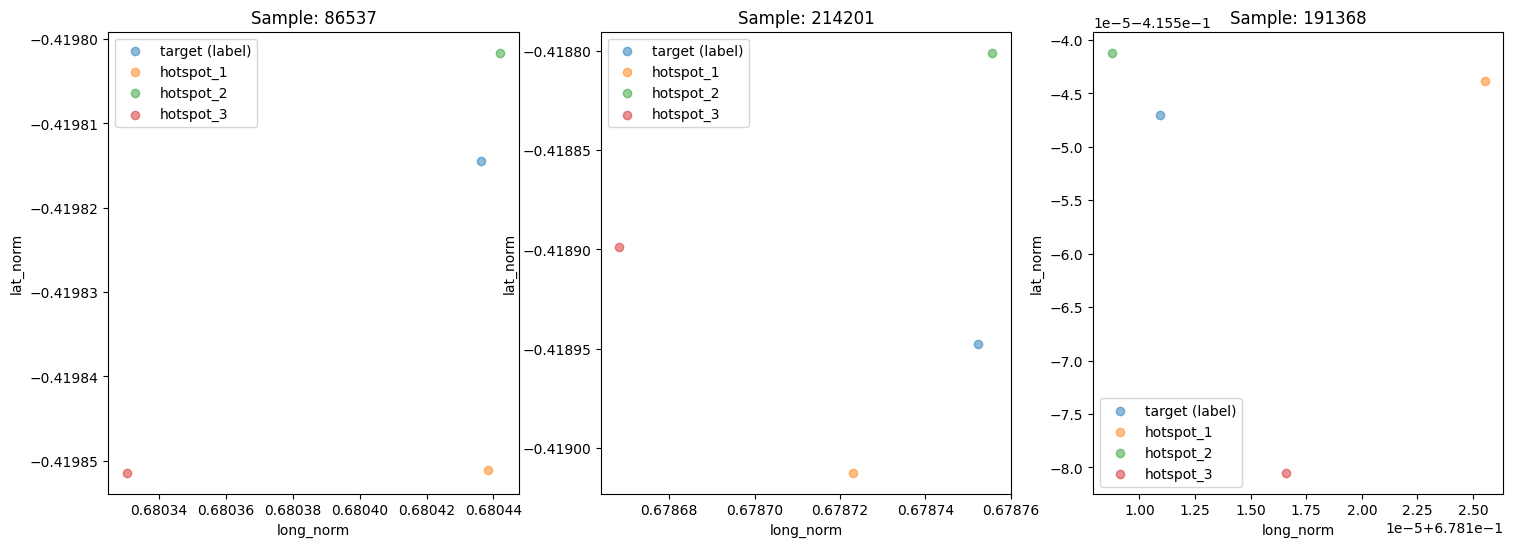

In [66]:
# Visualize a few samples and labels
fig = plt.figure(figsize=(18,6))
dim_names = ["long_norm", "lat_norm"] if DATA_MODE == "geo" else ["x_norm", "y_norm", "z_norm"]
for i in range(3):
    sample_idx = np.random.randint(0, y_train.shape[0])
    ax = fig.add_subplot(1,3,i+1, projection='3d' if DATA_MODE == "cartesian" else None)
    coord_idxs = [label_cols.index(f"target_{dim_name}") for dim_name in dim_names]
    ax.scatter(*(y_train[sample_idx, c_idx] for c_idx in coord_idxs), alpha=0.5, label="target (label)")
    for hs_idx in range(1,4):
        coord_idxs = [sample_cols.index(f"hotspot{hs_idx}_{dim_name}") for dim_name in dim_names]
        ax.scatter(*(x_train[sample_idx, c_idx] for c_idx in coord_idxs), alpha=0.5, label=f"hotspot_{hs_idx}")
        ax.set_xlabel(dim_names[0])
        ax.set_ylabel(dim_names[1])
        if len(dim_names) > 2:
            ax.set_zlabel(dim_names[2])
    ax.legend()
    ax.set_title(f"Sample: {sample_idx}")
plt.show()

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [68]:
torch.manual_seed(42)

Xtr, Ytr = torch.tensor(x_train).float().to(device), torch.tensor(y_train).float().to(device)
Xval, Yval = torch.tensor(x_val).float().to(device), torch.tensor(y_val).float().to(device)
Yval_NAIVE = torch.tensor(y_val_naive).float().to(device)
def get_batch(batch_size:int =32, is_train: bool=True):
    # generate a small batch of data of inputs x and targets y
    src_data = Xtr if is_train else Xval
    labels = Ytr if is_train else Yval
    ix = torch.randint(0, src_data.shape[0], (batch_size,))
    return src_data[ix], labels[ix]

# Loss Functions

Geometric distances between lat/long are NOT linear across the range of lat/long.... so use other coordinates or distance metrics when calculating loss


In [69]:
def cartesian_loss_func(pred_norm_lat_long: Tensor, labels_norm_lat_long: Tensor)->Tensor:
    # Convert norm lat/long to cart xyz
    pred_xyz = convert_lat_long_to_cart_xyz_TORCH(denorm_lat_long(pred_norm_lat_long))
    labels_xyz = convert_lat_long_to_cart_xyz_TORCH(denorm_lat_long(labels_norm_lat_long))
    return F.mse_loss(pred_xyz, labels_xyz)

def haversine_loss_func(pred_norm_lat_long: Tensor, labels_norm_lat_long: Tensor)->Tensor:
    dist = haversine_torch(denorm_lat_long(pred_norm_lat_long), denorm_lat_long(labels_norm_lat_long))
    # square to penalize larger errors more significantly
    sq_dist = dist ** 2 
    return torch.mean(sq_dist)

def equirectangular_loss_func(pred_norm_lat_long: Tensor, labels_norm_lat_long: Tensor)->Tensor:
    dist = equirectangular_torch(denorm_lat_long(pred_norm_lat_long), denorm_lat_long(labels_norm_lat_long))
    # square to penalize larger errors more significantly
    sq_dist = dist ** 2 
    return torch.mean(sq_dist)

# Model

In [70]:
class MlpTriangulationModel(nn.Module):
    def __init__(
        self, 
        input_size: int, 
        output_size: int, 
        hidden_layer_size: int = 64, 
        n_hidden_layers: int = 5, 
        b_norm: bool = True,
        loss_func = None
    ):
        super().__init__()
        fan_in_out = [
            (input_size, hidden_layer_size)
        ] + (n_hidden_layers - 1) * [(hidden_layer_size, hidden_layer_size)]
        layers = [
            # Flatten the data for each node into a single vector like so: [x1,y1,ss1, x2,y2,ss2...]
            nn.Flatten(start_dim=1)
        ]
        for fan_in, fan_out in fan_in_out:
            layers += (
                [nn.Linear(fan_in, fan_out, bias=not b_norm)]
                + ([nn.BatchNorm1d(fan_out)] if b_norm else [])
                + [nn.ReLU()]
            )

        layers.append(nn.Linear(fan_in_out[-1][-1], output_size))
        # parameter init
        with torch.no_grad():
            layers[-1].weight *= 0.1  # make last layer less confident
        self.layers = nn.Sequential(*layers)

        self.loss_func = F.mse_loss if loss_func is None else loss_func

    def forward(self, samples: Tensor, targets: Tensor = None) -> Tuple[Tensor, Tensor]:
        logits = self.layers(samples)
        if targets is None:
            loss = None
        else:
            loss = self.loss_func(logits, targets)
            # loss = haversine_loss_func(pred_norm_lat_long=logits, labels_norm_lat_long=targets)
            # loss = equirectangular_loss_func(pred_norm_lat_long=logits, labels_norm_lat_long=targets)
            # loss = cartesian_loss_func(pred_norm_lat_long=logits, labels_norm_lat_long=targets)
            # loss = F.mse_loss(logits, targets)
            # loss = F.l1_loss(logits, targets)
        return logits, loss


In [71]:
# Create model
if DATA_MODE == "geo":
    loss_func = haversine_loss_func
    # init_lr = 1e-3
    init_lr = 1e-4
    # loss_func = equirectangular_loss_func
    # init_lr = 1e-5
else:
    loss_func = F.mse_loss
    init_lr = 1e-4

model = MlpTriangulationModel(
    input_size = x_train.shape[-1], # number of channels/features in each input sample
    output_size = y_train.shape[-1], # number of predicted dimensions... ie: 2 - geo, or 3 - cartesian
    loss_func = loss_func
)

model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

0.01837 M parameters


In [72]:
if False:
    # Find a good learning rate
    lri = []
    lossi = []
    lre = torch.linspace(-6, -3, 1000)
    lrs = 10**lre
    BATCH_SIZE = 256
    for i, lr in enumerate(lrs):
        for g in optimizer.param_groups:
            g['lr'] = lr
        # Get a random batch
        Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

        # Predict coordinates and evaluate loss
        logits, loss = model(Xb,Yb)
        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        lri.append(lr.item())
        lossi.append(loss.item())

    plt.plot(lri, lossi)
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")

# Training

In [73]:
# Training
BATCH_SIZE = 256
MAX_STEPS = 30000
# LR_DECAY = [MAX_STEPS//15, MAX_STEPS//3, 4*MAX_STEPS//5]
LR_DECAY = [12000]
PRINT_INTERVAL = MAX_STEPS // 25
stats = []

def evaluate(data:Tensor, labels:Tensor)->Tuple[float, float]:
    with torch.no_grad():
        predictions, _ = model(data)
    
    r_earth = 6373.0 # radius of the earth in km
    if DATA_MODE == "geo":
        dist_err_km = haversine_torch(
            denorm_lat_long(predictions), 
            denorm_lat_long(labels), 
            radius= 6373.0 # radius of the earth in km
        ).cpu().numpy()
    elif DATA_MODE == "cartesian":
        dist_err_norm = np.linalg.norm(predictions.cpu().numpy() - labels.cpu().numpy(), axis=1)
        dist_err_km = r_earth * dist_err_norm
    else:
        raise ValueError(f"Unsupported mode: {DATA_MODE}")
    
    return dist_err_km.mean(), dist_err_km.std()


model.train()
lr = init_lr
for i in range(MAX_STEPS):
    # Get a random batch
    Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

    # Predict coordinates and evaluate loss
    logits, loss = model(Xb,Yb)
    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    step_stats = {
        "step": i,
        "loss": loss.item(),
        "lr": lr
    }
    if i % PRINT_INTERVAL == 0:
        with torch.no_grad():
            val_error_mean, val_error_std = evaluate(data=Xval, labels=Yval)
            step_stats["val_error_dist_km_mean"] = val_error_mean
            step_stats["val_error_dist_km_std"] = val_error_std
        print(f"Step: {i},\t Loss: {loss.item():.6f},\tValErrDist: mean = {val_error_mean:.4f} km (std:: {val_error_std:.4f})")
    if i in LR_DECAY:
        print("Adjusting LR")
        for g in optimizer.param_groups:
            lr = lr * 0.1
            g['lr'] *= 0.1
    stats.append(step_stats)


Step: 0,	 Loss: 4.312436,	ValErrDist: mean = 13158.2559 km (std:: 445.3648)
Step: 1200,	 Loss: 0.001819,	ValErrDist: mean = 198.3774 km (std:: 152.2369)
Step: 2400,	 Loss: 0.001329,	ValErrDist: mean = 135.7666 km (std:: 104.6118)
Step: 3600,	 Loss: 0.000681,	ValErrDist: mean = 111.7340 km (std:: 83.1457)
Step: 4800,	 Loss: 0.000358,	ValErrDist: mean = 89.1343 km (std:: 66.6721)
Step: 6000,	 Loss: 0.000680,	ValErrDist: mean = 78.6531 km (std:: 57.2350)
Step: 7200,	 Loss: 0.000421,	ValErrDist: mean = 74.4930 km (std:: 48.2102)
Step: 8400,	 Loss: 0.000250,	ValErrDist: mean = 57.7967 km (std:: 46.1076)
Step: 9600,	 Loss: 0.000228,	ValErrDist: mean = 64.9785 km (std:: 45.5946)
Step: 10800,	 Loss: 0.000094,	ValErrDist: mean = 46.2083 km (std:: 33.5959)
Step: 12000,	 Loss: 0.000084,	ValErrDist: mean = 46.4251 km (std:: 28.6651)
Adjusting LR
Step: 13200,	 Loss: 0.000102,	ValErrDist: mean = 36.7207 km (std:: 27.3296)
Step: 14400,	 Loss: 0.000088,	ValErrDist: mean = 35.7192 km (std:: 26.3618)
St

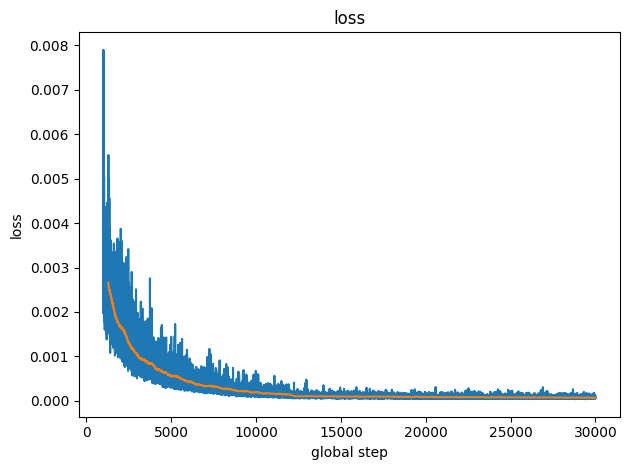

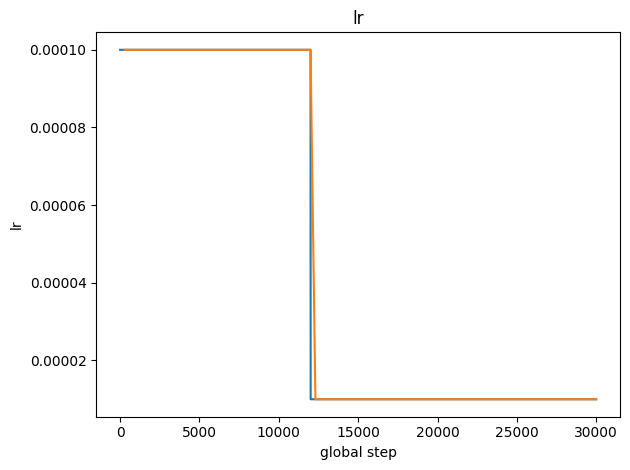

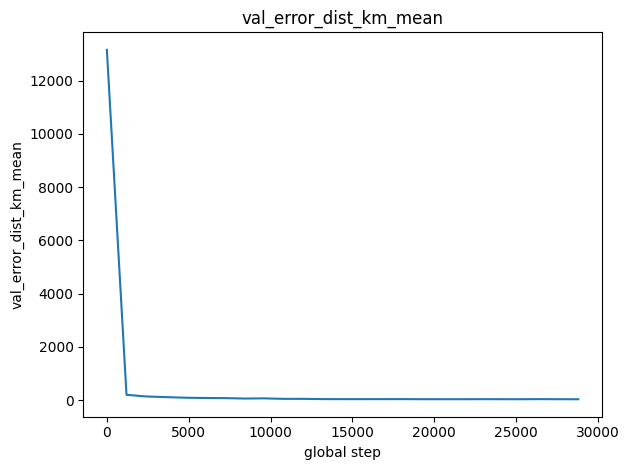

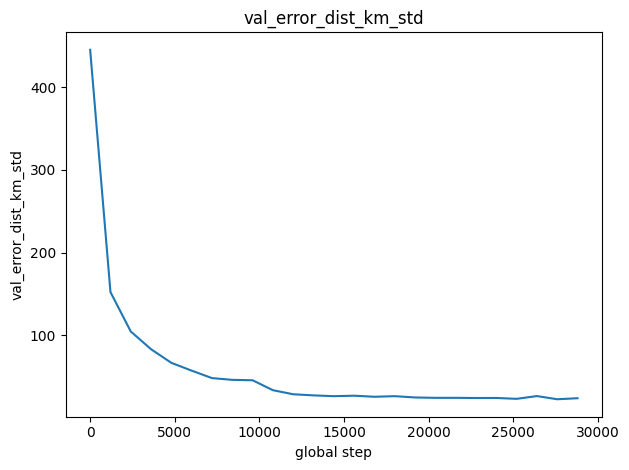

In [74]:
plot_contents = {}
for i, step_stats in enumerate(stats):
    step = step_stats.pop("step", i)
    for k, v in step_stats.items():
        if k not in plot_contents:
            plot_contents[k] = {"x": [], "y":[]}
        plot_contents[k]["x"].append(step)
        plot_contents[k]["y"].append(v)
for k, v in plot_contents.items():
    x, y = np.asarray(v["x"]), np.asarray(v["y"])
    if k == "loss":
        x = x[1000:]
        y = y[1000:]
    plt.figure()
    plt.title(k)
    plt.plot(x,y)
    n = y.shape[0] // 100
    if n > 10:
        smoothed = np.convolve(y, np.ones(n), 'valid') / n
        smoothed = np.average(np.lib.stride_tricks.sliding_window_view(y, n), axis=1)
        plt.plot(x[n-1:], smoothed, label="Smoothed")
    plt.xlabel("global step")
    plt.ylabel(k)
    plt.tight_layout()


# Inference

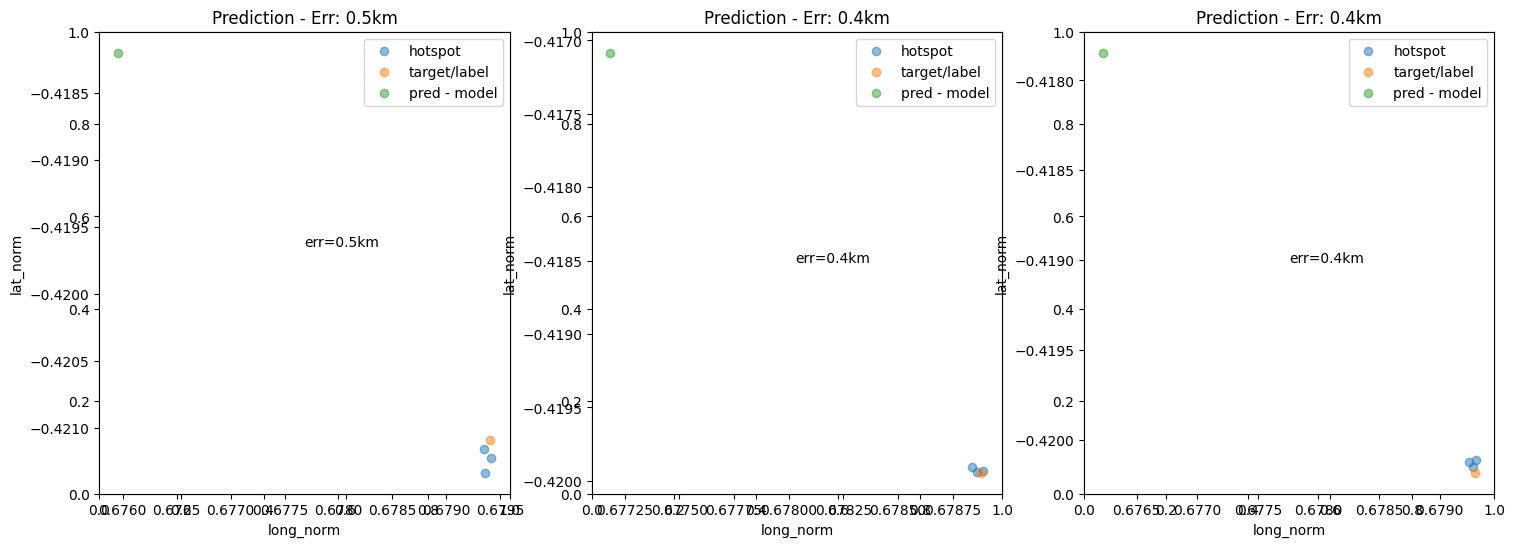

In [82]:
# Predict
samples, labels = get_batch(batch_size=3, is_train=False)
model.eval()
with torch.no_grad():
    predictions, _ = model(samples)

fig = plt.figure(figsize=(18,6))
dim_names = ["long_norm", "lat_norm"] if DATA_MODE == "geo" else ["x_norm", "y_norm", "z_norm"]
for i, sample, label, pred in zip(list(range(len(samples))), samples.cpu(), labels.cpu(), predictions.cpu()):
    ax = fig.add_subplot(1,3,i+1, projection='3d' if DATA_MODE == "cartesian" else None)

    hs_coords = [
        [sample[sample_cols.index(f"hotspot{i}_{suffix}")] for i in range(1,4)] for suffix in dim_names
    ]
    label_c_idxs = [label_cols.index(f"target_{dim_name}") for dim_name in dim_names]
    label_coords = tuple(label[c_idx] for c_idx in label_c_idxs)
    pred_coords = tuple(pred[c_idx] for c_idx in label_c_idxs)
    r_earth_km = 6373.0 # radius of the earth in km
    r_earth_m = 1000 * r_earth_km
    if DATA_MODE == "geo":
        dist_err_km = haversine_np(
            np.expand_dims(pred.numpy(),0), 
            np.expand_dims(label.numpy(),0), 
            radius=r_earth_km
        )[0]
    elif DATA_MODE == "cartesian":
        dist_err_km = haversine_np(
            cartesian_to_geo(xyz_m=r_earth_m*pred.numpy()),
            cartesian_to_geo(xyz_m=r_earth_m*label.numpy()),
            radius=r_earth_km
        )[0]
    else:
        raise ValueError(f"Unsupported mode: {DATA_MODE}")
    
    ax = fig.add_subplot(1,3,i+1, projection='3d' if DATA_MODE == "cartesian" else None)
    ax.set_title(f"Prediction - Err: {dist_err_km:.1f}km")
    ax.set_xlabel(dim_names[0])
    ax.set_ylabel(dim_names[1])
    if len(dim_names) > 2:
        ax.set_zlabel(dim_names[2])
    ax.scatter(
        *tuple(hs_coords),
        alpha=0.5,
        label="hotspot",
    )
    ax.scatter(*label_coords, alpha=0.5, label="target/label")
    ax.scatter(*pred_coords, alpha=0.5, label="pred - model")
    mid = (pred + label) / 2
    if len(mid) == 2:
        ax.annotate(f"err={dist_err_km:.1f}km", xy=tuple(mid[c_idx] for c_idx in label_c_idxs))
    ax.legend()
plt.show()

In [83]:
# Calculate errors for the entire validation set
model.eval()
with torch.no_grad():
    predictions, _ = model(Xval)

r_earth_km = 6373.0 # radius of the earth in km
r_earth_m = r_earth_km * 1000
if DATA_MODE == "geo":
    dist_err_km = haversine_torch(denorm_lat_long(predictions), denorm_lat_long(Yval), radius=r_earth_km).cpu().numpy()
    naive_tri_dist_err_km = haversine_torch(denorm_lat_long(Yval_NAIVE), denorm_lat_long(Yval), radius=r_earth_km).cpu().numpy()
elif DATA_MODE == "cartesian":
    dist_err_km = haversine_np(
        cartesian_to_geo(xyz_m=r_earth_m*predictions.cpu().numpy()),
        cartesian_to_geo(xyz_m=r_earth_m*Yval.cpu().numpy()),
        radius=r_earth_km
    )
    naive_tri_dist_err_km = haversine_np(
        cartesian_to_geo(xyz_m=r_earth_m*Yval_NAIVE.cpu().numpy()),
        cartesian_to_geo(xyz_m=r_earth_m*Yval.cpu().numpy()),
        radius=r_earth_km
    )
else:
    raise ValueError(f"Unsupported data mode {DATA_MODE}")

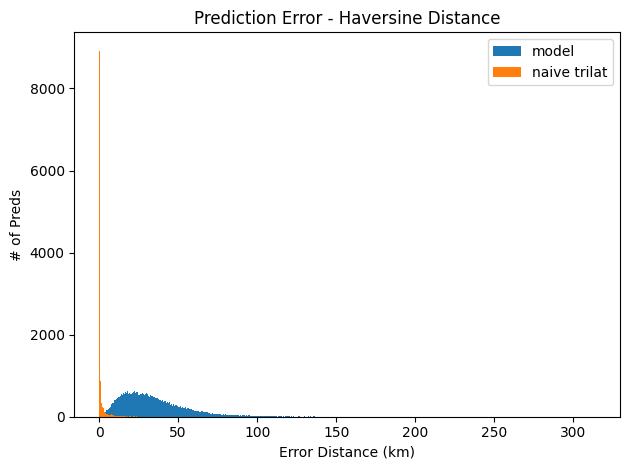

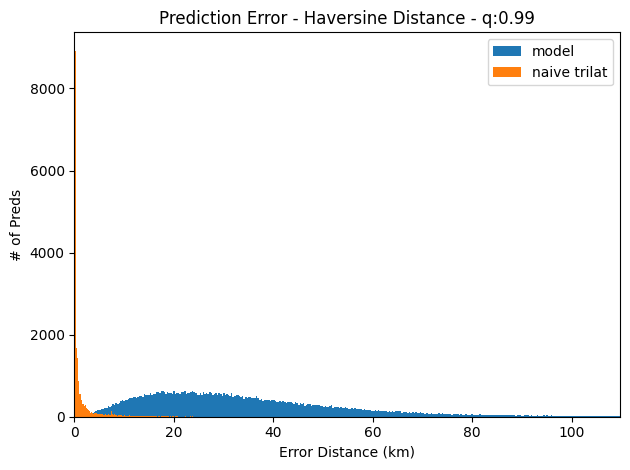

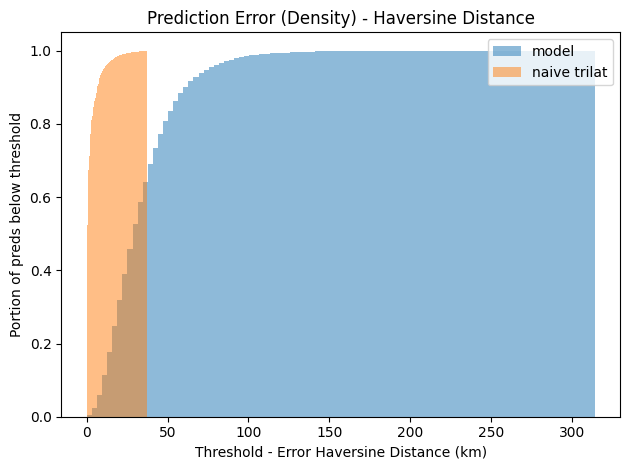

In [87]:
# Look at distribution:
plt.hist(dist_err_km, bins=1000, label="model")
plt.hist(naive_tri_dist_err_km, bins=1000, label="naive trilat")
plt.title("Prediction Error - Haversine Distance")
plt.xlabel("Error Distance (km)")
plt.ylabel("# of Preds")
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in
plt.figure()
plt.hist(dist_err_km, bins=1000, label="model")
plt.hist(naive_tri_dist_err_km, bins=1000, label="naive trilat")
plt.title("Prediction Error - Haversine Distance - q:0.99")
plt.xlim(0, np.quantile(dist_err_km, 0.99))
plt.xlabel("Error Distance (km)")
plt.ylabel("# of Preds")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.title("Prediction Error (Density) - Haversine Distance")
plt.hist(dist_err_km, bins=100, alpha=0.5, density=True, cumulative=True, label="model")
plt.hist(naive_tri_dist_err_km, bins=100, alpha=0.5, density=True, cumulative=True, label="naive trilat")
plt.xlabel("Threshold - Error Haversine Distance (km)")
plt.ylabel("Portion of preds below threshold")
plt.legend()
plt.tight_layout()
plt.show()